In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

from neuropacks import ECOG
from tuning_plot_utils import *

%matplotlib inline

# ECoG

In [7]:
results = h5py.File('fits/ecog/ecog.h5', 'r')
ecog = ECOG(
    data_path='/Users/psachdeva/data/ECoG/data/r32_b7.mat',
    grid_path='/Users/psachdeva/data/ECoG/data/grdid.mat'
)

hg_bf_lasso = results['HG_bf_Lasso']
hg_bf_UoI_R2 = results['HG_bf_UoI_Lasso_R2']

lasso_coefs = np.mean(hg_bf_lasso['tuning_coefs'], axis=0)
lasso_intercepts = np.mean(hg_bf_lasso['intercepts'], axis=0)

uoi_r2_coefs = np.mean(hg_bf_UoI_R2['tuning_coefs'], axis=0)
uoi_r2_intercepts = np.mean(hg_bf_UoI_R2['intercepts'], axis=0)

results.close()

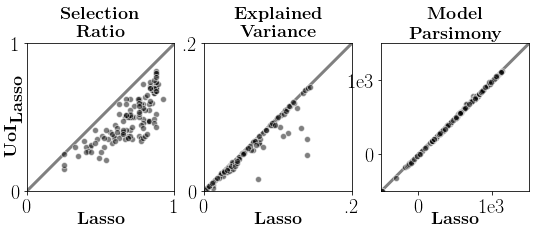

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

plot_metric('fits/ecog/ecog.h5', metric='selection_ratio', x='HG_bf_Lasso', y='HG_bf_UoI_Lasso_R2', ax=axes[0])
plot_metric('fits/ecog/ecog.h5', metric='r2', x='HG_bf_Lasso', y='HG_bf_UoI_Lasso_R2', ax=axes[1])
plot_metric('fits/ecog/ecog.h5', metric='BIC', x='HG_bf_Lasso', y='HG_bf_UoI_Lasso_R2', ax=axes[2])

axes[0].set_xlim([0, 1])
axes[0].set_xticks([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_yticks([0, 1])
axes[0].plot([0, 1], [0, 1], color='gray', linewidth=3, zorder=-1)
axes[0].set_aspect('equal')

axes[1].set_xlim([0, 0.2])
axes[1].set_xticks([0, 0.2])
axes[1].set_xticklabels(['0', '.2'])
axes[1].set_ylim([0, 0.2])
axes[1].set_yticks([0, 0.2])
axes[1].set_yticklabels(['0', '.2'])
axes[1].plot([0, 1], [0, 1], color='gray', linewidth=3, zorder=-1)
axes[1].set_aspect('equal')

bounds = [-500, 1500]
axes[2].set_xlim(bounds)
axes[2].set_ylim(bounds)
axes[2].set_xticks([0, 1000])
axes[2].set_xticklabels(['0', '1e3'])
axes[2].set_yticks([0, 1000])
axes[2].set_yticklabels(['0', '1e3'])
axes[2].plot(bounds, bounds, color='gray', linewidth=3, zorder=-1)
axes[2].set_aspect('equal')

axes[0].set_title(r'\textbf{Selection}' '\n' r'\textbf{Ratio}', fontsize=18)
axes[1].set_title(r'\textbf{Explained}' '\n' r'\textbf{Variance}', fontsize=18)
axes[2].set_title(r'\textbf{Model}' '\n' r'\textbf{Parsimony}', fontsize=18)

axes[0].set_xlabel(r'\textbf{Lasso}', fontsize=18, labelpad=-5)
axes[1].set_xlabel(r'\textbf{Lasso}', fontsize=18, labelpad=-5)
axes[2].set_xlabel(r'\textbf{Lasso}', fontsize=18, labelpad=-5)

axes[0].set_ylabel(r'\textbf{UoI}$_{\textbf{Lasso}}$', fontsize=18, labelpad=-15)

plt.savefig('ecog_redwood.pdf', bbox_inches='tight')

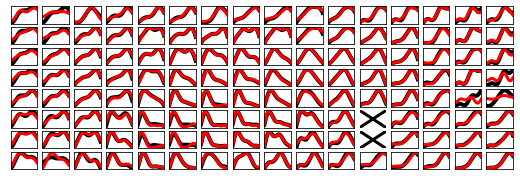

In [11]:
fig, axes = plt.subplots(8, 16, figsize=(9, 3))

for electrode in range(ecog.n_electrodes):
    x, y = ecog.get_xy_for_electrode(electrode)

    if x == 5 and y == 11:
        axes[x, y].plot(np.arange(-100, 100), np.arange(-100, 100), color='k', linewidth=3)
        axes[x, y].plot(np.arange(-100, 100), -np.arange(-100, 100), color='k', linewidth=3)
        axes[x, y].axis('off')
    elif x == 6 and y == 11:
        axes[x, y].plot(np.arange(-100, 100), np.arange(-100, 100), color='k', linewidth=3)
        axes[x, y].plot(np.arange(-100, 100), -np.arange(-100, 100), color='k', linewidth=3)
        axes[x, y].axis('off')
    else:
        frequencies, lasso_tc = ecog.get_tuning_curve(
            tuning_coefs=lasso_coefs[electrode]
        )
        _, uoi_r2_tc = ecog.get_tuning_curve(
            tuning_coefs=uoi_r2_coefs[electrode]
        )

        axes[x, y].plot(
            frequencies, lasso_intercepts[electrode] + lasso_tc,
            color='k',
            linewidth=4,
            alpha=1,
            zorder=-1,
            label=r'\textbf{Lasso}'
        )
        axes[x, y].plot(
            frequencies, uoi_r2_intercepts[electrode] + uoi_r2_tc,
            color='r',
            linewidth=3,
            alpha=1,
            label=r'\textbf{UoI}$_{\textbf{Lasso}}-R^2$'
        )

        axes[x, y].set_xscale('log')
        axes[x, y].set_xlim([frequencies[0], frequencies[-1]])
        axes[x, y].set_xticks([])
        axes[x, y].set_yticks([])



# fig.text(
#     x=0.5, y=0.06,
#     s=r'\textbf{Log Frequency}',
#     horizontalalignment='center',
#     verticalalignment='center',
#     fontsize=15    
# )

plt.savefig('ecog2_redwood.pdf', bbox_inches='tight')

# Retinal STRF

In [2]:
f = h5py.File('fits/ret1/20080516_R2.h5', 'r')
recordings = list(f)
n_recordings = len(recordings)

In [3]:
selection_ratio_lasso = np.zeros(n_recordings)
selection_ratio_uoi = np.zeros(n_recordings)

for idx, recording in enumerate(recordings):
    lasso_strf = f[recording]['Lasso/strf'][:]
    selection_ratio_lasso[idx] = (1 + np.count_nonzero(lasso_strf))/(1 + lasso_strf.size)
    
    uoi_strf = f[recording]['UoI_AIC/strf'][:]
    selection_ratio_uoi[idx] = (1 + np.count_nonzero(uoi_strf))/(1 + uoi_strf.size)

In [4]:
dr2_lasso = np.zeros(n_recordings)
dr2_uoi = np.zeros(n_recordings)

for idx, recording in enumerate(recordings):
    lasso_r2 = f[recording]['Lasso/r2s_test'][:]
    dr2_lasso[idx] = np.max(lasso_r2) - np.min(lasso_r2)
    
    uoi_r2 = f[recording]['UoI_AIC/r2s_test'][:]
    dr2_uoi[idx] = np.max(uoi_r2) - np.min(uoi_r2)

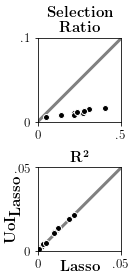

In [5]:
fig, axes = plt.subplots(2, 1, figsize=(2, 4))

axes[0].scatter(
    selection_ratio_lasso,
    selection_ratio_uoi,
    alpha=1,
    color='k',
    edgecolor='w')
axes[0].plot([0, 0.1], [0, 0.1], color='gray', linewidth=3, zorder=-1)
axes[0].set_xlim([0, 0.1])
axes[0].set_xticks([0, 0.1])
axes[0].set_xticklabels(['0', '.5'])
axes[0].set_ylim([0, 0.1])
axes[0].set_yticks([0, 0.1])
axes[0].set_yticklabels(['0', '.1'])
axes[0].tick_params(labelsize=13)
axes[0].set_title(r'\textbf{Selection}' '\n' r'\textbf{Ratio}', fontsize=15)
axes[0].set_aspect('equal')

axes[1].scatter(
    dr2_lasso,
    dr2_uoi,
    alpha=1,
    color='k',
    edgecolor='w')

axes[1].plot([0, 0.05], [0, 0.05], color='gray', linewidth=3, zorder=-1)
axes[1].set_xlim([0, 0.05])
axes[1].set_xticks([0, 0.05])
axes[1].set_xticklabels(['0', '.05'])
axes[1].set_ylim([0, 0.05])
axes[1].set_yticks([0, 0.05])
axes[1].set_yticklabels(['0', '.05'])
axes[1].tick_params(labelsize=13)
axes[1].set_title(r'$\mathbf{R^2}$', fontsize=15)
axes[1].set_aspect('equal')
axes[1].set_xlabel(r'\textbf{Lasso}', fontsize=15, labelpad=-10)
axes[1].set_ylabel(r'\textbf{UoI}$_{\textbf{Lasso}}$', fontsize=15, labelpad=-8)

plt.tight_layout()
plt.savefig('figure4_redwood.pdf', bbox_inches='tight')

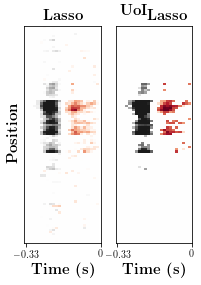

In [6]:
example = recordings[2]
lasso_strf = f[example]['Lasso/strf'][:]
uoi_strf = f[example]['UoI_AIC/strf'][:]

fig, axes = plt.subplots(1, 2, figsize=(3, 4))

axes[0].imshow(lasso_strf.T, cmap=plt.get_cmap('RdGy'), vmin=-1e-6, vmax=1e-6)
axes[0].set_aspect('auto')
axes[0].tick_params(labelsize=10)
axes[0].set_yticks(np.arange(lasso_strf.shape[0]))

axes[1].imshow(uoi_strf.T, cmap=plt.get_cmap('RdGy'), vmin=-1e-6, vmax=1e-6)
axes[1].set_aspect('auto')
axes[1].tick_params(labelsize=10)
axes[1].set_yticks(np.arange(uoi_strf.shape[0]))

axes[0].set_xticks([0, 24])
axes[0].set_xticklabels([r'$-0.33$', r'$0$'])
axes[0].set_xlabel(r'\textbf{Time (s)}', fontsize=15)

axes[1].set_xticks([0, 24])
axes[1].set_xticklabels([r'$-0.33$', r'$0$'])
axes[1].set_xlabel(r'\textbf{Time (s)}', fontsize=15)

axes[0].set_ylabel(r'\textbf{Position}', fontsize=15)
for ax in axes:
    ax.set_ylim([150, 250])

axes[0].set_title(r'\textbf{Lasso}', fontsize=15)
axes[1].set_title(r'\textbf{UoI}$_{\textbf{Lasso}}$', fontsize=15)
plt.savefig('figure4_2_redwood.pdf', bbox_inches='tight')